[example data](https://drive.google.com/file/d/1TDtsTcT108uPwDhpOQDmy-khTChlYzwK/view?usp=drive_link)
- unzip and upload to your google drive
- replace with your data with same folder structure

In [8]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


copy to colab server for faster data loading

In [20]:
!cp -r "/content/gdrive/MyDrive/dataset_cup_pis" .

train

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler


dataset_name = 'dataset_cup_pis'


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Load data
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.Resize((224,224)),
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.9, 1.1)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.1)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        # transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

train_ds = datasets.ImageFolder(root=dataset_name + '/training_data/', transform=data_transforms['train'])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)

val_ds = datasets.ImageFolder(root=dataset_name +'/validation_data/', transform=data_transforms['val'])
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=8, num_workers=2)

# Model
number_of_classes = len(train_ds.classes)

model = models.mobilenet_v3_small(pretrained=True)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = torch.nn.Linear(num_ftrs, number_of_classes)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)


# # Freeze all model parameters - if I have small dataset
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the classifier part (the last few layers)
# for param in model.classifier.parameters():
#     param.requires_grad = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10,13], gamma=0.1)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, train_predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, val_predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {running_loss/len(train_loader)}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


model = model.to('cpu')

save model for mobile app

In [9]:
from torch.utils.mobile_optimizer import optimize_for_mobile
print(torch.__version__)

save_path = '/content/gdrive/MyDrive/models_for_app'
model_name = '_cup_pis'

model = model.eval()
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model, example)
# traced_script_module = optimize_for_mobile(traced_script_module) ## faster but can be less correct (not at all working, why?)
traced_script_module._save_for_lite_interpreter(save_path + '/model' + model_name + '.ptl')

model_lite = torch.jit.load(save_path + '/model' + model_name + '.ptl')

with open(save_path +'/classes' + model_name + '.txt', 'w') as file:
    for cls in train_ds.classes:
        file.write(f"{cls}\n")

try model on uploaded images

Predicted class: pis


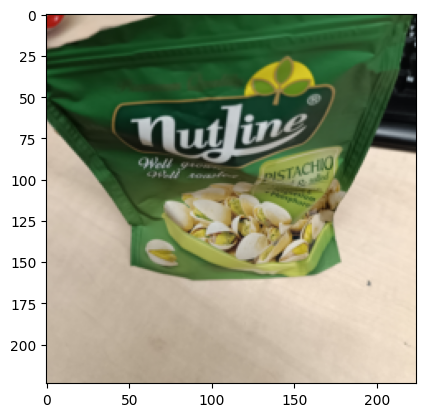

Predicted class: cup


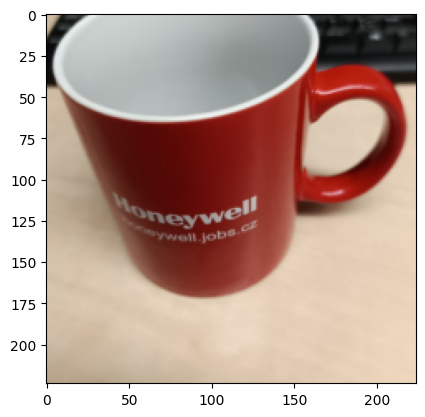

In [24]:
# Test with an uploaded image - with lite model
from google.colab import files
import glob

uploaded = files.upload()
file_names = list(uploaded.keys())

# file_names = glob.glob('/content/*.jpg')

def unnormalize(tensor):
    for i in range(3):
        tensor[i] = (tensor[i] * std[i]) + mean[i]
    return tensor



for file_name in file_names:

    img = Image.open(file_name)
    img = data_transforms['val'](img).unsqueeze(0)

    outputs = model_lite(img)
    predicted_index = outputs.argmax(1).item()

    print(f"Predicted class: {train_ds.classes[predicted_index]}")
    plt.imshow(unnormalize(img[0,:,:,:]).cpu().numpy().transpose(1, 2, 0))
    plt.show()